<a href="https://colab.research.google.com/github/yisehakalelign/gdsc_study_session_ML_g1/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini project: Ride price estimation

name: Yisehak Alelign


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

rows = 200   # more than 150

data = {
    "distance_km": np.random.uniform(1, 20, rows),
    "duration_min": np.random.uniform(5, 60, rows),
    "time_of_day": np.random.choice(["Morning", "Afternoon", "Evening", "Night"], rows),
    "traffic_level": np.random.choice(["Low", "Medium", "High"], rows),
    "weather": np.random.choice(["Clear", "Rainy"], rows),
    "demand_level": np.random.choice(["Low", "High"], rows),
}

df = pd.DataFrame(data)

# Create ride price formula (simple logic)
df["ride_price"] = (
    df["distance_km"] * 5 +
    df["duration_min"] * 0.5 +
    np.where(df["traffic_level"] == "High", 10, 0) +
    np.where(df["weather"] == "Rainy", 5, 0) +
    np.where(df["demand_level"] == "High", 8, 0)
)

df.head()


,distance_km,duration_min,time_of_day,traffic_level,weather,demand_level,ride_price
0,8.116262,40.311741,Morning,Medium,Clear,Low,60.737182
1,19.063572,9.627698,Afternoon,High,Rainy,Low,115.131708
2,14.907885,13.889579,Morning,Low,Rainy,High,94.484214
3,12.374511,54.420480,Morning,Low,Rainy,High,102.082796
4,3.964354,38.353598,Afternoon,Low,Rainy,High,51.998570


# ML Mindset & Problem Framing

Learning Problem:

This is a supervised learning regression problem because we are predicting a continuous value (ride_price).

Why ML instead of fixed rules?

Because pricing depends on many interacting factors (traffic, demand, weather). ML can learn patterns automatically instead of using fixed formulas.

What should the model learn?

The relationship between trip features and ride price.

# Data Exploration

In [2]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance_km    200 non-null    float64
 1   duration_min   200 non-null    float64
 2   time_of_day    200 non-null    object 
 3   traffic_level  200 non-null    object 
 4   weather        200 non-null    object 
 5   demand_level   200 non-null    object 
 6   ride_price     200 non-null    float64
dtypes: float64(3), object(4)
memory usage: 11.1+ KB


,0
distance_km,0
duration_min,0
time_of_day,0
traffic_level,0
weather,0
demand_level,0
ride_price,0


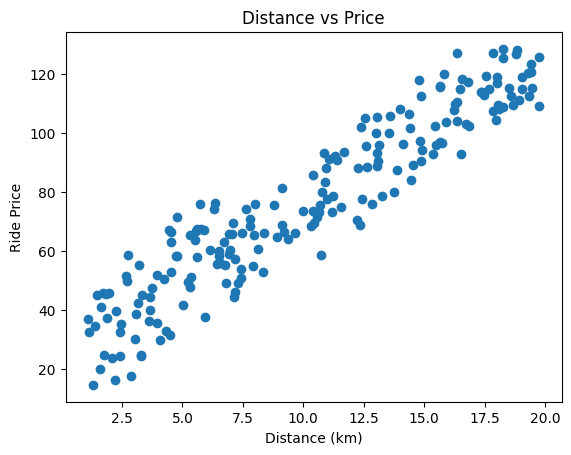

In [3]:
import matplotlib.pyplot as plt

plt.scatter(df["distance_km"], df["ride_price"])
plt.xlabel("Distance (km)")
plt.ylabel("Ride Price")
plt.title("Distance vs Price")
plt.show()


# Data Cleaning & Feature Engineering

In [4]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,distance_km,duration_min,ride_price,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,traffic_level_Low,traffic_level_Medium,weather_Rainy,demand_level_Low
0,8.116262,40.311741,60.737182,False,True,False,False,True,False,True
1,19.063572,9.627698,115.131708,False,False,False,False,False,True,True
2,14.907885,13.889579,94.484214,False,True,False,True,False,True,False
3,12.374511,54.420480,102.082796,False,True,False,True,False,True,False
4,3.964354,38.353598,51.998570,False,False,False,True,False,True,False


In [10]:
X = df_encoded.drop("ride_price", axis=1)
y = df_encoded["ride_price"]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Regression Model (Linear Regression)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 1.971756091734278e-14
R2 Score: 1.0


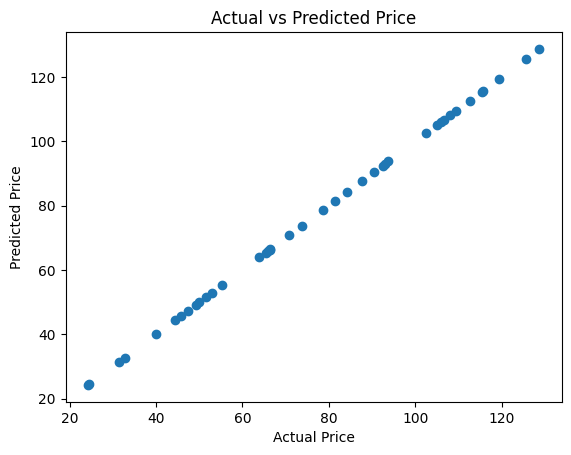

In [14]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()


In [15]:
df_encoded["high_cost"] = np.where(df_encoded["ride_price"] > df_encoded["ride_price"].median(), 1, 0)


In [16]:
X_class = df_encoded.drop(["ride_price", "high_cost"], axis=1)
y_class = df_encoded["high_cost"]


In [17]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

clf = LogisticRegression()
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_c))


Accuracy: 1.0
Confusion Matrix:
 [[20  0]
 [ 0 20]]


# Classification (High Cost vs Low Cost)

Most Influential Feature:

Distance_km likely has strongest effect because price increases directly with distance.

One unfair pricing behavior:

If demand_level is always high in poor neighborhoods, prices may become unfair.

Real-world risk:

Model may overcharge during emergencies (rain, high demand).

Dataset limitation:

Synthetic data may not reflect real-world pricing patterns.